In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 100
beta = torch.linspace(900e-4, 500e-4, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0007, device='cuda:0')

In [3]:
alpha_

tensor([9.1000e-01, 8.2847e-01, 7.5458e-01, 6.8758e-01, 6.2681e-01, 5.7166e-01,
        5.2160e-01, 4.7613e-01, 4.3482e-01, 3.9726e-01, 3.6312e-01, 3.3205e-01,
        3.0377e-01, 2.7803e-01, 2.5458e-01, 2.3321e-01, 2.1373e-01, 1.9596e-01,
        1.7975e-01, 1.6495e-01, 1.5144e-01, 1.3910e-01, 1.2781e-01, 1.1750e-01,
        1.0806e-01, 9.9428e-02, 9.1524e-02, 8.4285e-02, 7.7653e-02, 7.1574e-02,
        6.6000e-02, 6.0887e-02, 5.6194e-02, 5.1886e-02, 4.7929e-02, 4.4293e-02,
        4.0951e-02, 3.7878e-02, 3.5050e-02, 3.2448e-02, 3.0052e-02, 2.7845e-02,
        2.5812e-02, 2.3937e-02, 2.2208e-02, 2.0613e-02, 1.9141e-02, 1.7782e-02,
        1.6527e-02, 1.5366e-02, 1.4294e-02, 1.3302e-02, 1.2384e-02, 1.1535e-02,
        1.0748e-02, 1.0020e-02, 9.3448e-03, 8.7190e-03, 8.1386e-03, 7.6001e-03,
        7.1004e-03, 6.6363e-03, 6.2053e-03, 5.8048e-03, 5.4324e-03, 5.0862e-03,
        4.7641e-03, 4.4643e-03, 4.1851e-03, 3.9252e-03, 3.6829e-03, 3.4571e-03,
        3.2465e-03, 3.0501e-03, 2.8668e-

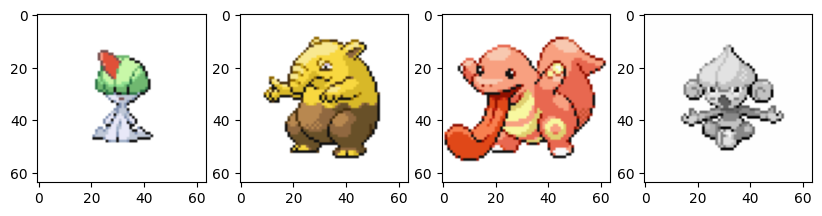

In [4]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|                                                                                                                                       | 0/100001 [00:00<?, ?it/s]

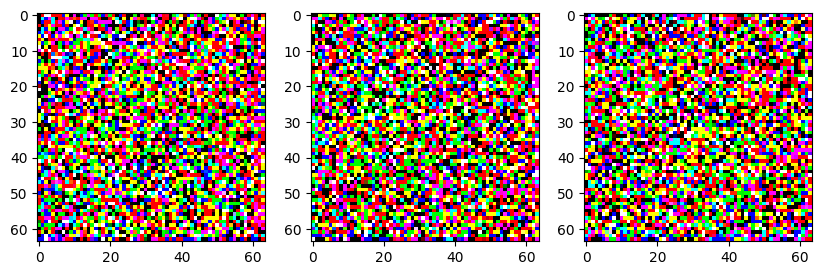

0.05193893:   1%|█                                                                                                              | 999/100001 [01:27<2:22:41, 11.56it/s]

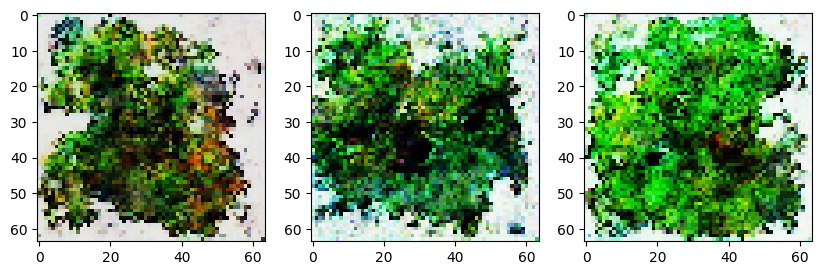

0.04499699:   2%|██▏                                                                                                           | 1999/100001 [02:55<2:21:17, 11.56it/s]

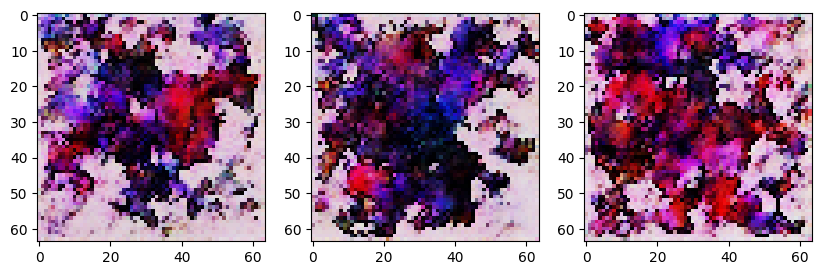

0.01579160:   3%|███▎                                                                                                          | 2999/100001 [04:23<2:19:31, 11.59it/s]

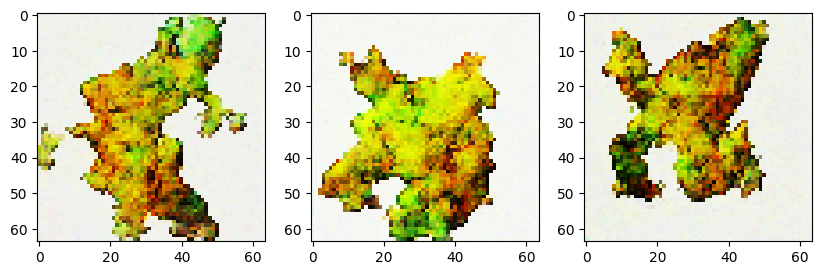

0.04779015:   4%|████▍                                                                                                         | 3999/100001 [05:51<2:17:50, 11.61it/s]

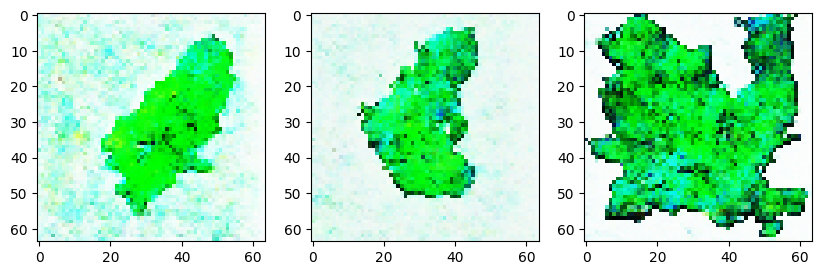

0.01558714:   5%|█████▍                                                                                                        | 4999/100001 [07:19<2:18:04, 11.47it/s]

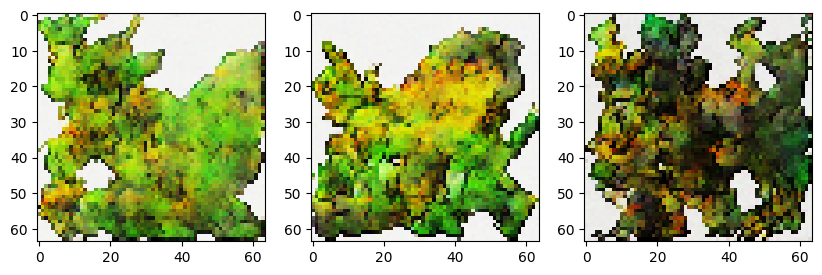

0.02885136:   6%|██████▌                                                                                                       | 5999/100001 [08:47<2:16:01, 11.52it/s]

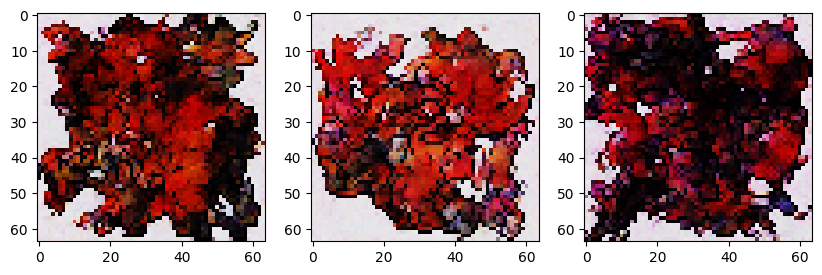

0.03099285:   7%|███████▋                                                                                                      | 6999/100001 [10:15<2:13:48, 11.58it/s]

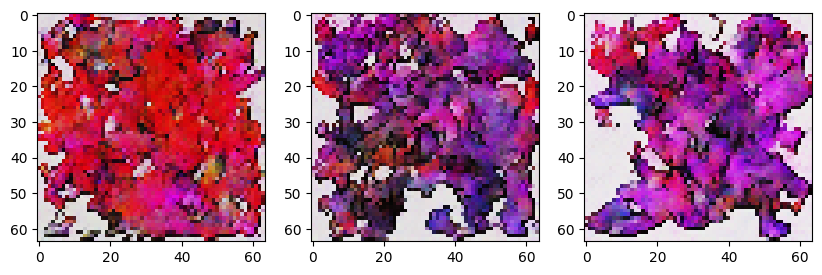

0.03633130:   8%|████████▊                                                                                                     | 7999/100001 [11:43<2:12:10, 11.60it/s]

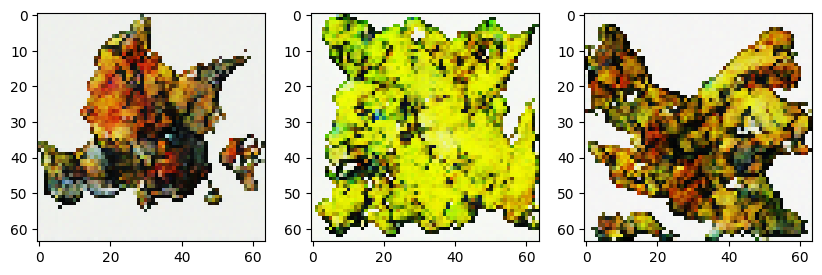

0.03895202:   9%|█████████▉                                                                                                    | 8999/100001 [13:11<2:11:13, 11.56it/s]

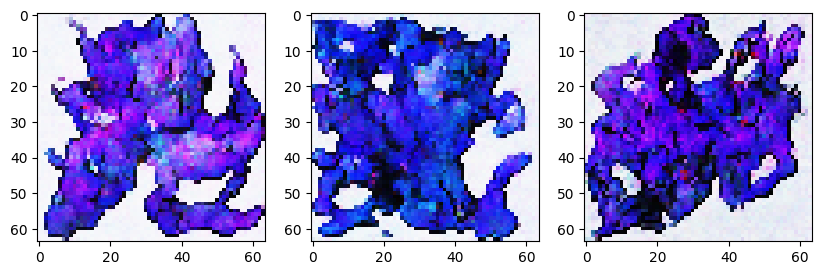

0.02536285:  10%|██████████▉                                                                                                   | 9999/100001 [14:39<2:10:10, 11.52it/s]

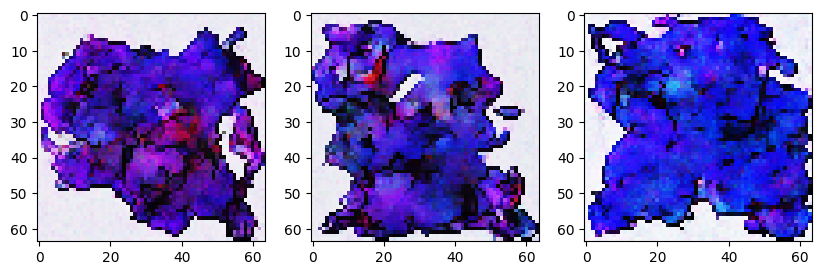

0.03538729:  11%|███████████▉                                                                                                 | 10999/100001 [16:06<2:07:51, 11.60it/s]

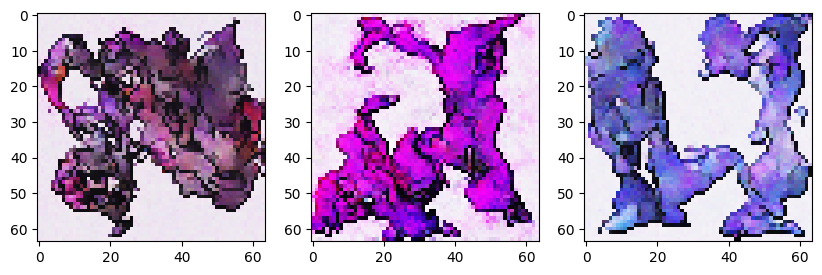

0.04073342:  12%|█████████████                                                                                                | 11999/100001 [17:34<2:06:41, 11.58it/s]

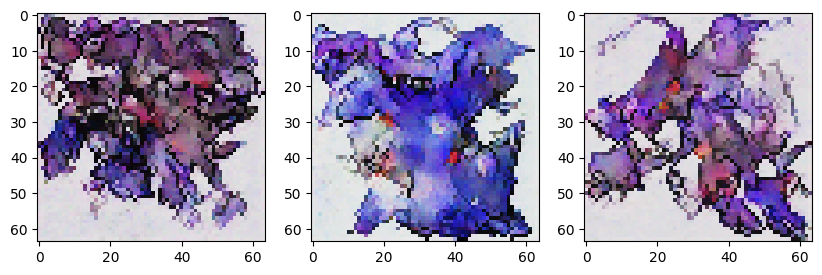

0.02134676:  13%|██████████████▏                                                                                              | 12999/100001 [19:02<2:05:08, 11.59it/s]

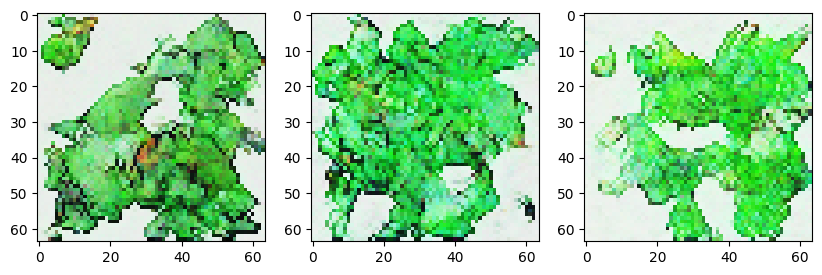

0.01791335:  14%|███████████████▎                                                                                             | 13999/100001 [20:30<2:03:38, 11.59it/s]

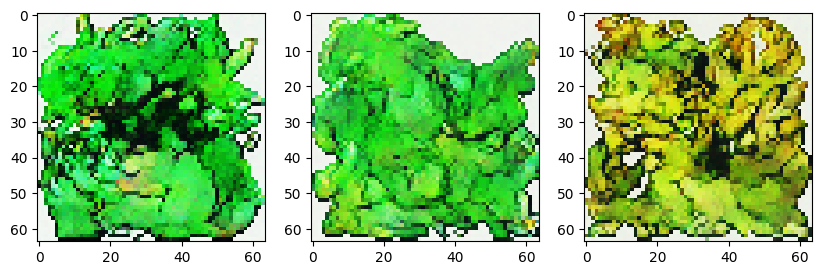

0.02367086:  15%|████████████████▎                                                                                            | 14999/100001 [21:58<2:02:08, 11.60it/s]

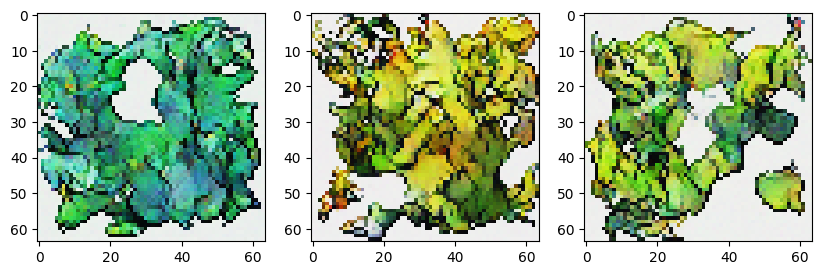

0.05218239:  16%|█████████████████▍                                                                                           | 15999/100001 [23:25<2:00:43, 11.60it/s]

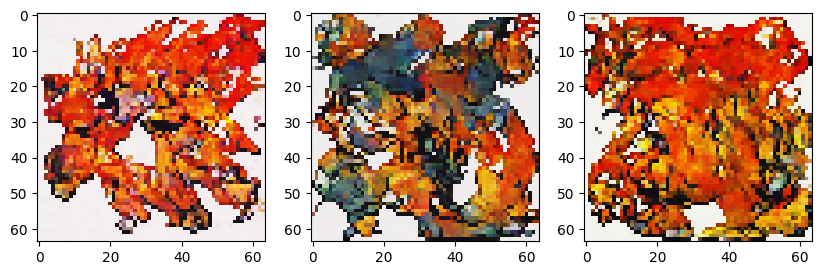

0.01743571:  17%|██████████████████▌                                                                                          | 16999/100001 [24:53<1:59:16, 11.60it/s]

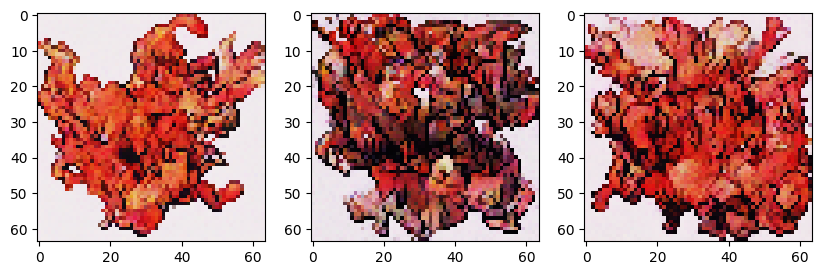

0.00673309:  18%|███████████████████▌                                                                                         | 17999/100001 [26:21<1:58:08, 11.57it/s]

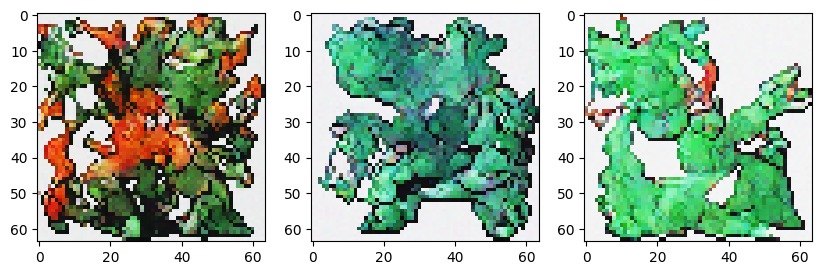

0.03738652:  19%|████████████████████▋                                                                                        | 18999/100001 [27:48<1:56:45, 11.56it/s]

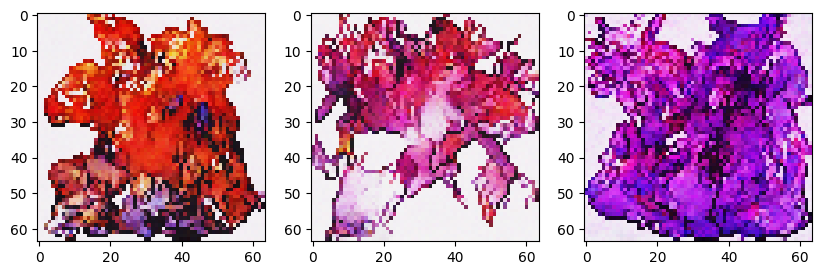

0.02614028:  20%|█████████████████████▊                                                                                       | 19999/100001 [29:16<1:55:05, 11.58it/s]

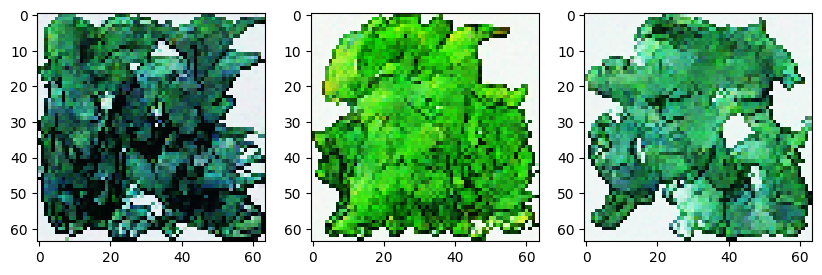

0.02314787:  21%|██████████████████████▉                                                                                      | 20999/100001 [30:44<1:53:31, 11.60it/s]

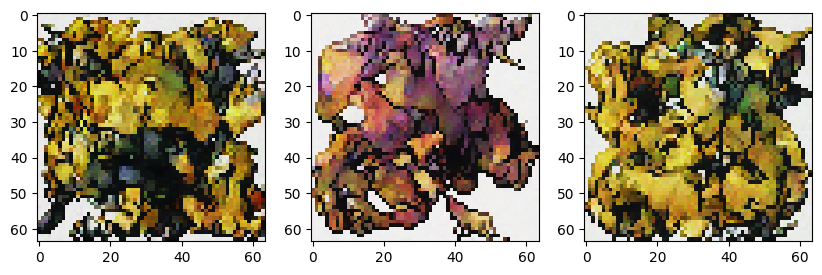

0.02295435:  22%|███████████████████████▉                                                                                     | 21999/100001 [32:12<1:52:07, 11.59it/s]

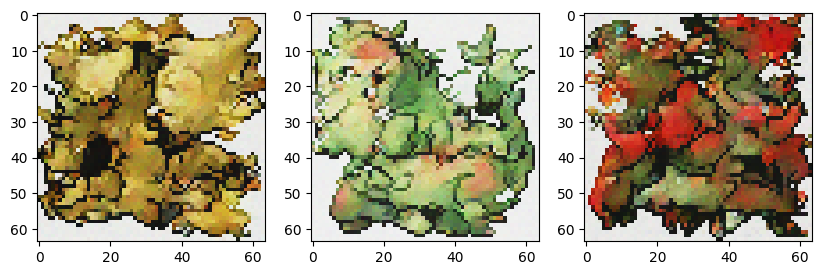

0.02321339:  23%|█████████████████████████                                                                                    | 22999/100001 [33:39<1:50:38, 11.60it/s]

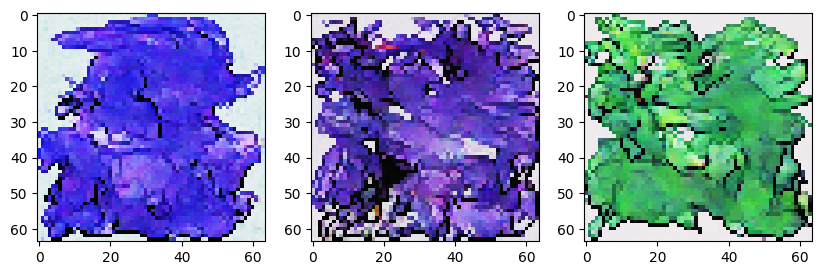

0.00821816:  24%|██████████████████████████▏                                                                                  | 23999/100001 [35:07<1:49:15, 11.59it/s]

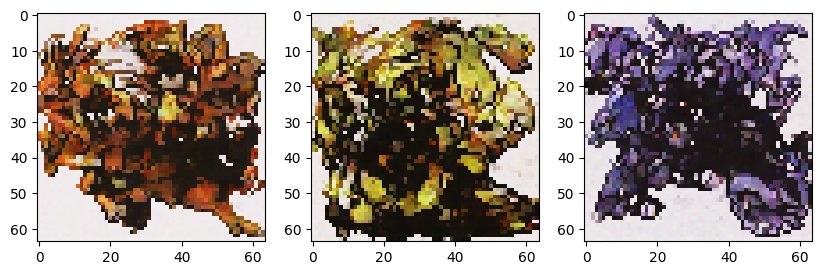

0.01969083:  25%|███████████████████████████▏                                                                                 | 24999/100001 [36:35<1:47:53, 11.59it/s]

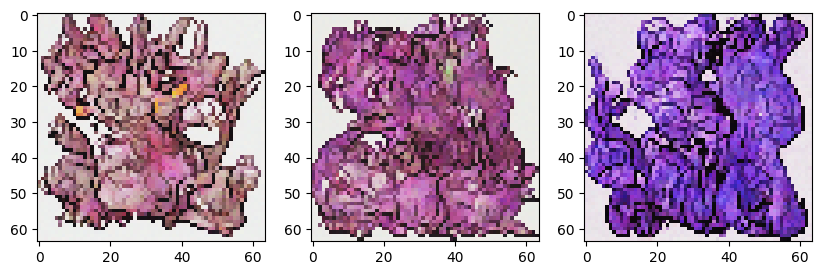

0.00699523:  26%|████████████████████████████▎                                                                                | 25999/100001 [38:03<1:46:28, 11.58it/s]

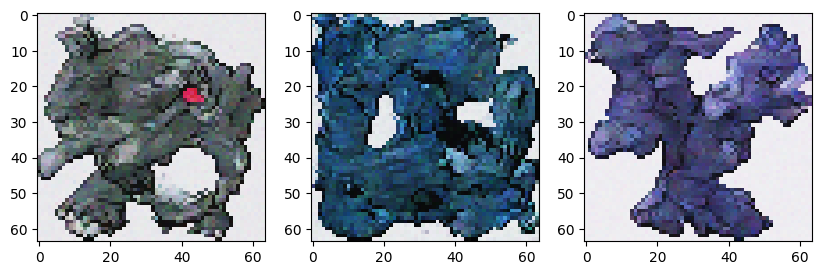

0.00928180:  27%|█████████████████████████████▍                                                                               | 26999/100001 [39:30<1:45:00, 11.59it/s]

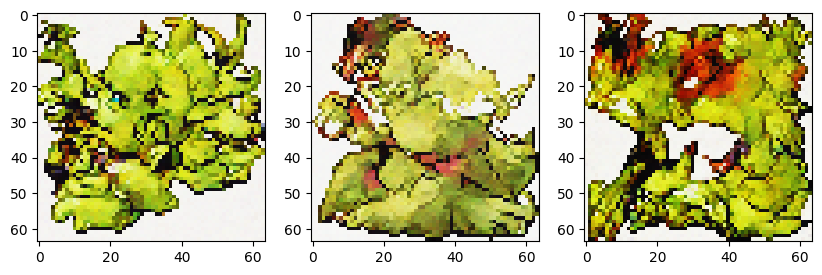

0.02330621:  28%|██████████████████████████████▌                                                                              | 27999/100001 [40:58<1:43:28, 11.60it/s]

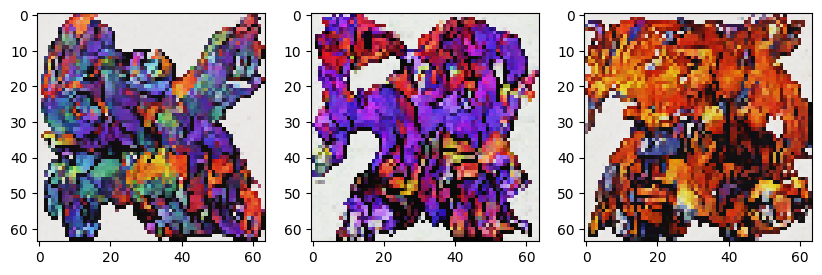

0.03007863:  29%|███████████████████████████████▌                                                                             | 28999/100001 [42:26<1:42:13, 11.58it/s]

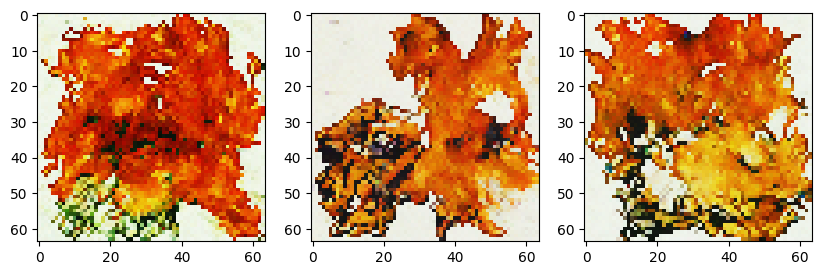

0.00967033:  30%|████████████████████████████████▋                                                                            | 29999/100001 [43:54<1:40:41, 11.59it/s]

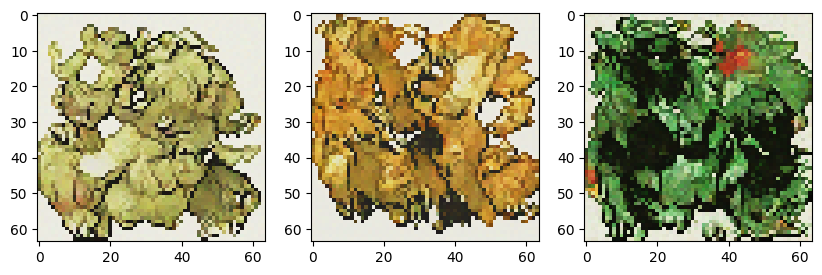

0.04002767:  31%|█████████████████████████████████▊                                                                           | 30999/100001 [45:21<1:39:13, 11.59it/s]

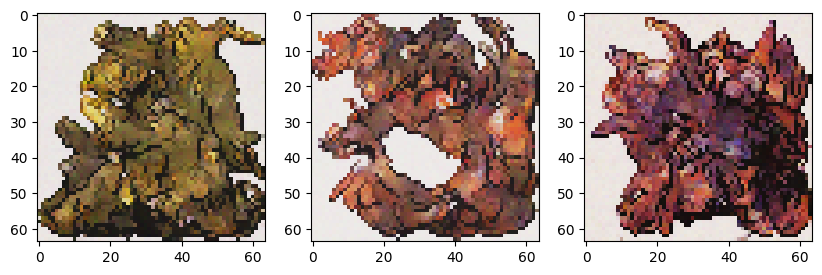

0.01367524:  32%|██████████████████████████████████▉                                                                          | 31999/100001 [46:49<1:37:43, 11.60it/s]

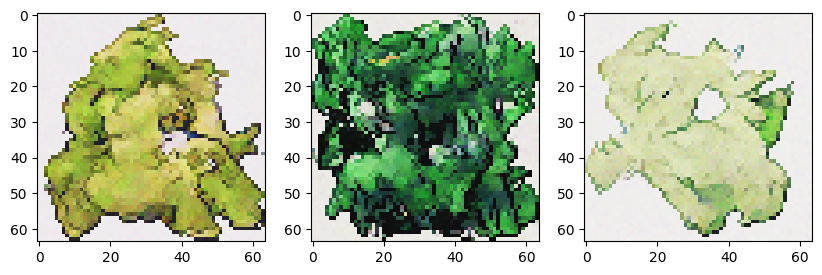

0.00779249:  33%|███████████████████████████████████▉                                                                         | 32999/100001 [48:17<1:36:21, 11.59it/s]

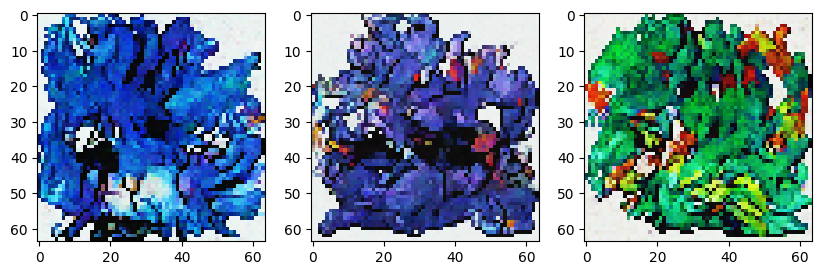

0.01270601:  34%|█████████████████████████████████████                                                                        | 33999/100001 [49:44<1:35:00, 11.58it/s]

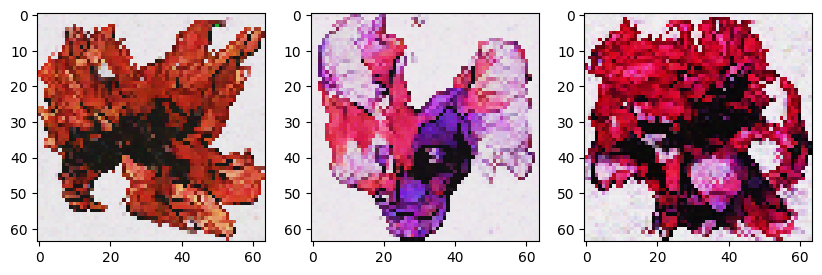

0.01486388:  35%|██████████████████████████████████████▏                                                                      | 34999/100001 [51:12<1:33:25, 11.60it/s]

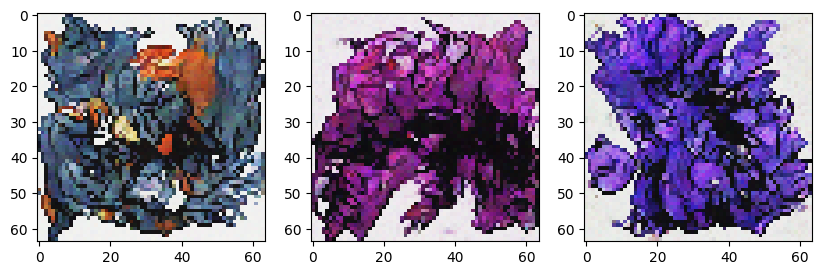

0.03009373:  36%|███████████████████████████████████████▏                                                                     | 35999/100001 [52:40<1:32:02, 11.59it/s]

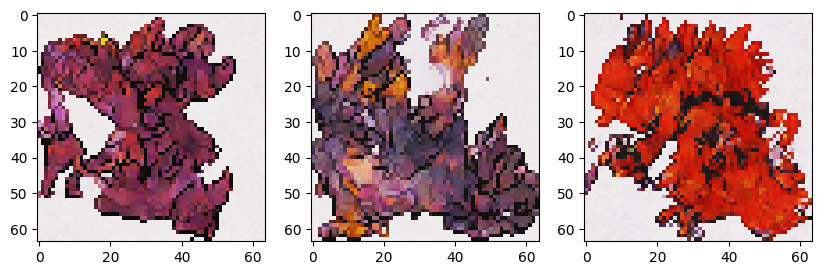

0.02338251:  37%|████████████████████████████████████████▎                                                                    | 36999/100001 [54:07<1:30:40, 11.58it/s]

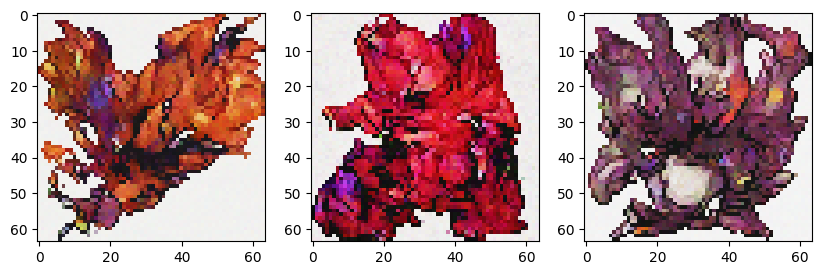

0.00829303:  38%|█████████████████████████████████████████▍                                                                   | 37999/100001 [55:35<1:29:10, 11.59it/s]

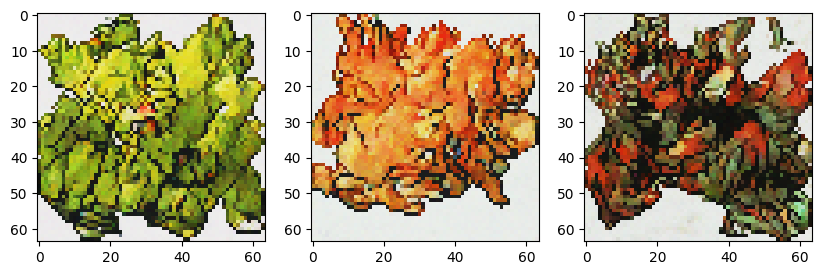

0.02078382:  39%|██████████████████████████████████████████▌                                                                  | 38999/100001 [57:03<1:27:38, 11.60it/s]

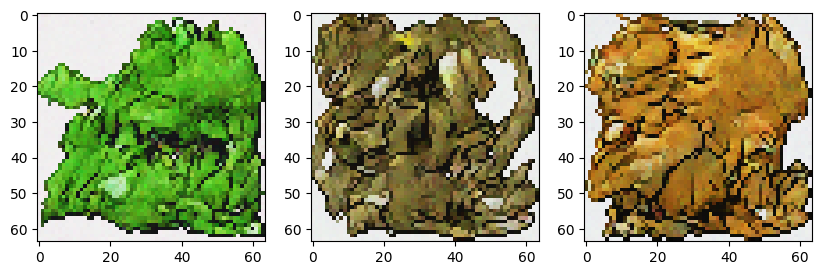

0.02410847:  40%|███████████████████████████████████████████▌                                                                 | 39999/100001 [58:31<1:26:21, 11.58it/s]

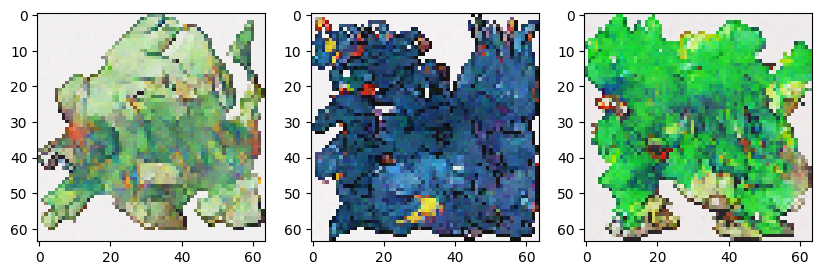

0.01131195:  41%|████████████████████████████████████████████▋                                                                | 40999/100001 [59:58<1:24:40, 11.61it/s]

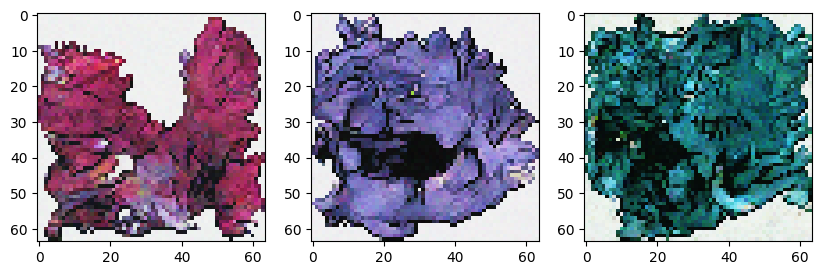

0.02300308:  42%|████████████████████████████████████████████▉                                                              | 41999/100001 [1:01:26<1:23:24, 11.59it/s]

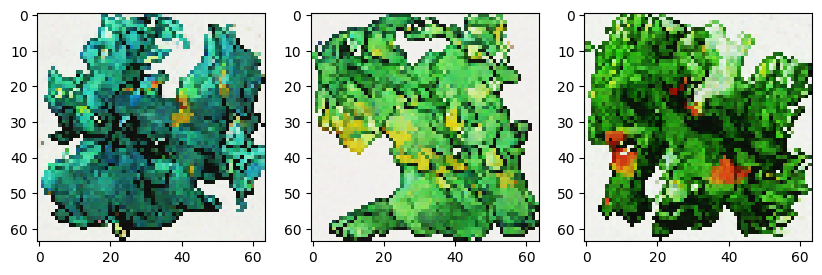

0.02120613:  43%|██████████████████████████████████████████████                                                             | 42999/100001 [1:02:54<1:22:04, 11.58it/s]

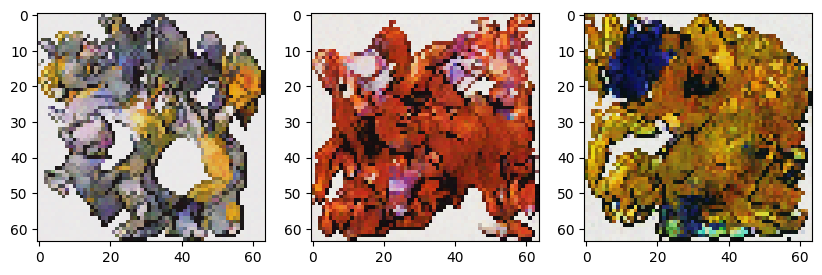

0.01560572:  44%|███████████████████████████████████████████████                                                            | 43999/100001 [1:04:22<1:20:38, 11.57it/s]

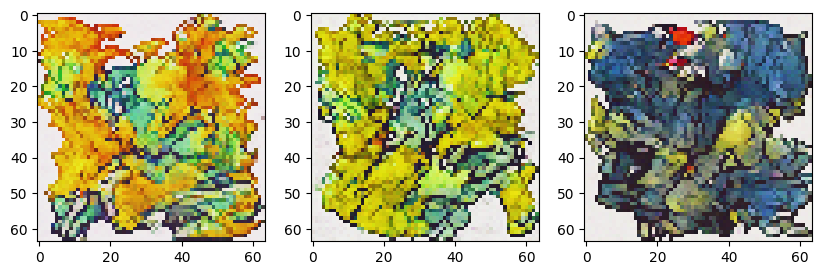

0.01367054:  45%|████████████████████████████████████████████████▏                                                          | 44999/100001 [1:05:49<1:19:06, 11.59it/s]

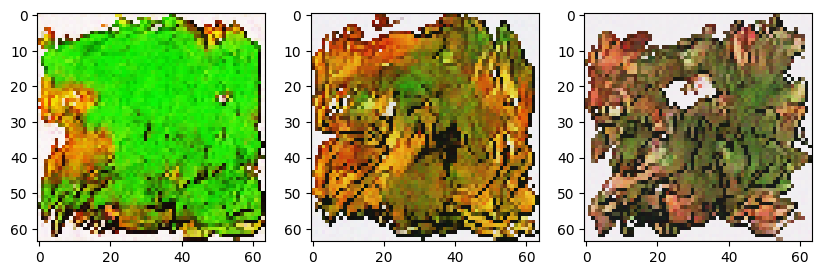

0.00529762:  46%|█████████████████████████████████████████████████▏                                                         | 45999/100001 [1:07:17<1:17:42, 11.58it/s]

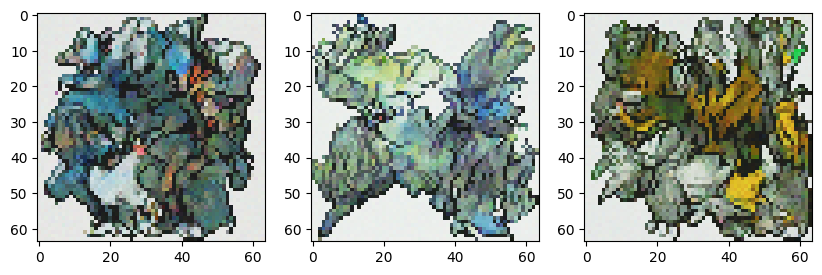

0.02305036:  47%|██████████████████████████████████████████████████▎                                                        | 46999/100001 [1:08:45<1:16:13, 11.59it/s]

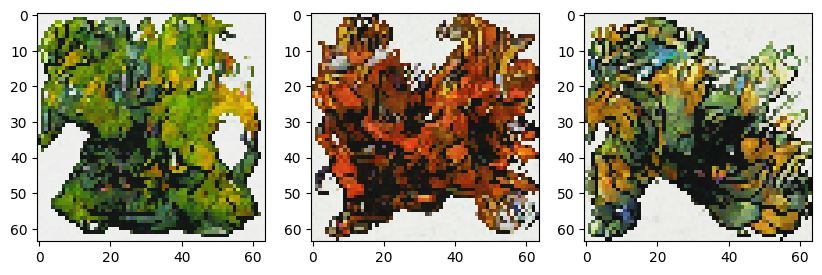

0.01152561:  48%|███████████████████████████████████████████████████▎                                                       | 47999/100001 [1:10:13<1:14:45, 11.59it/s]

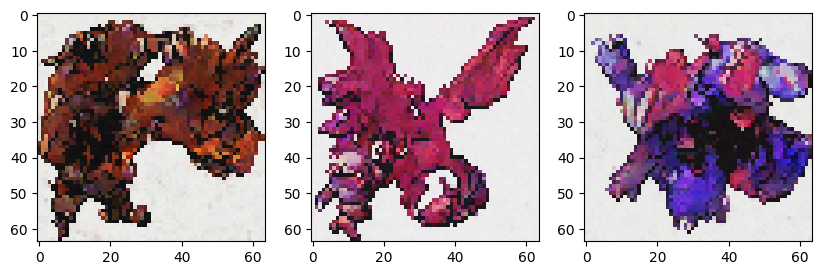

0.02229891:  49%|████████████████████████████████████████████████████▍                                                      | 48999/100001 [1:11:40<1:13:13, 11.61it/s]

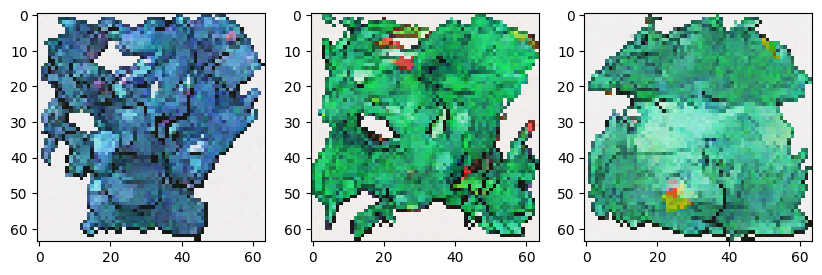

0.02564827:  50%|█████████████████████████████████████████████████████▍                                                     | 49999/100001 [1:13:08<1:12:00, 11.57it/s]

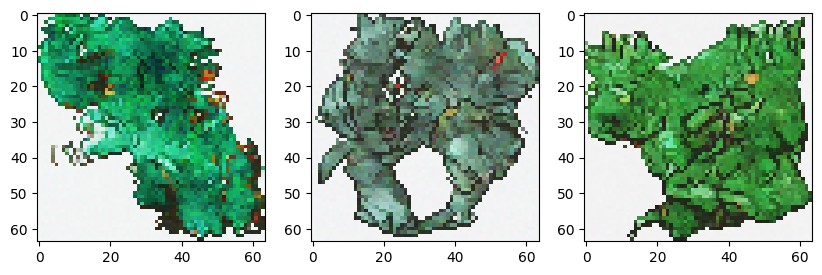

0.03385378:  51%|██████████████████████████████████████████████████████▌                                                    | 50999/100001 [1:14:36<1:10:24, 11.60it/s]

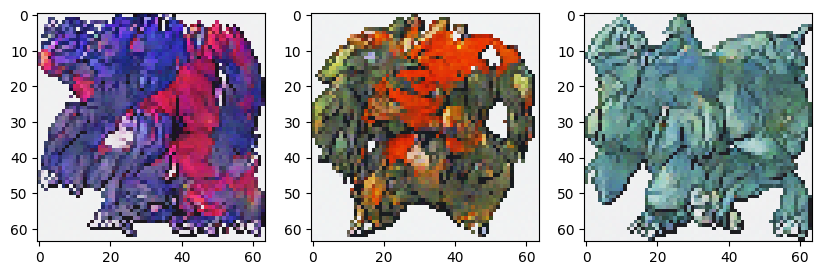

0.01304681:  52%|███████████████████████████████████████████████████████▋                                                   | 51999/100001 [1:16:03<1:09:01, 11.59it/s]

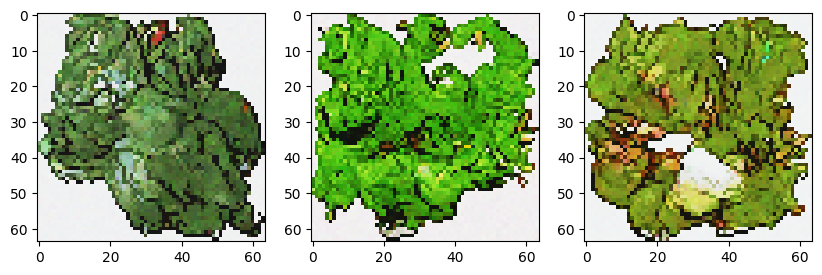

0.02116230:  53%|████████████████████████████████████████████████████████▋                                                  | 52999/100001 [1:17:31<1:07:41, 11.57it/s]

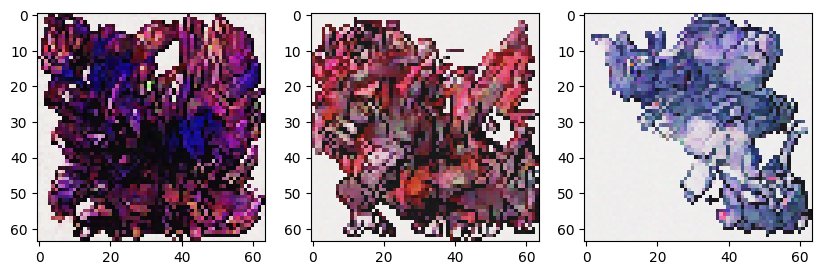

0.01625978:  54%|█████████████████████████████████████████████████████████▊                                                 | 53999/100001 [1:18:59<1:06:06, 11.60it/s]

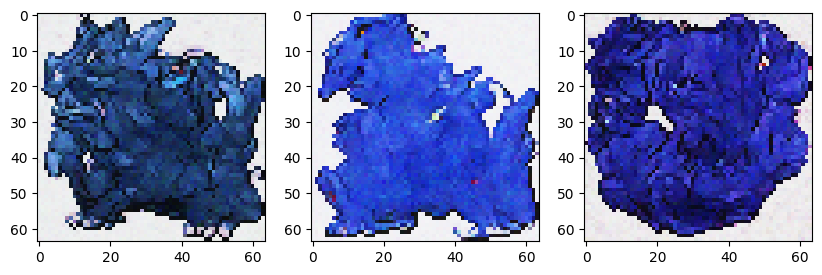

0.02425862:  55%|██████████████████████████████████████████████████████████▊                                                | 54999/100001 [1:20:27<1:04:48, 11.57it/s]

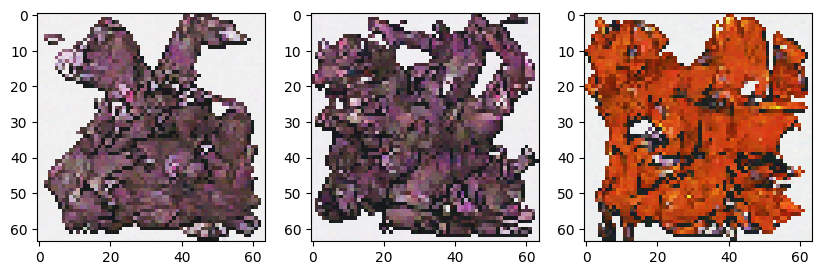

0.01836621:  56%|███████████████████████████████████████████████████████████▉                                               | 55999/100001 [1:21:55<1:03:18, 11.58it/s]

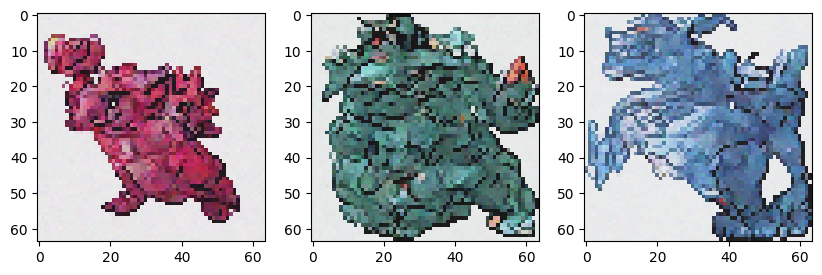

0.01697866:  57%|████████████████████████████████████████████████████████████▉                                              | 56999/100001 [1:23:22<1:01:51, 11.59it/s]

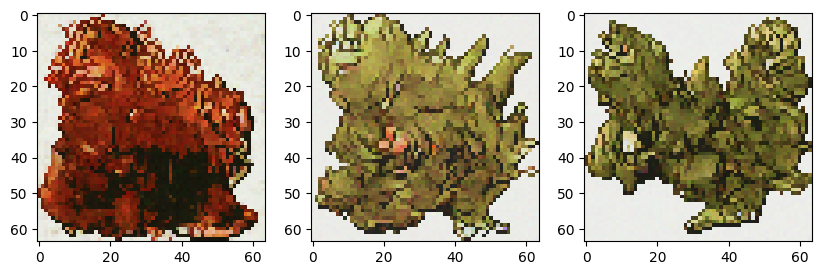

0.01335439:  58%|██████████████████████████████████████████████████████████████                                             | 57999/100001 [1:24:50<1:00:24, 11.59it/s]

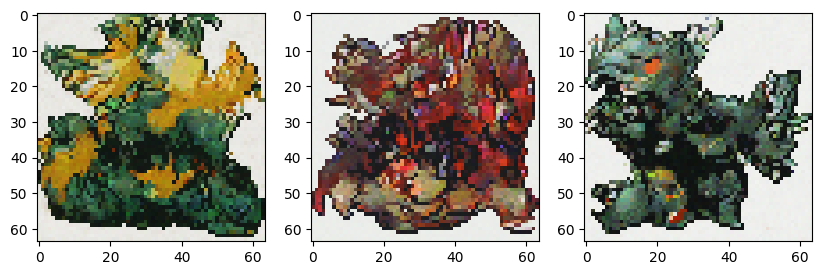

0.01797828:  59%|████████████████████████████████████████████████████████████████▎                                            | 58999/100001 [1:26:18<58:58, 11.59it/s]

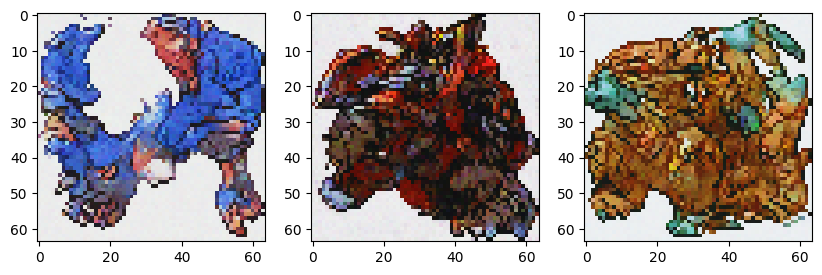

0.01703255:  60%|█████████████████████████████████████████████████████████████████▍                                           | 59999/100001 [1:27:46<57:31, 11.59it/s]

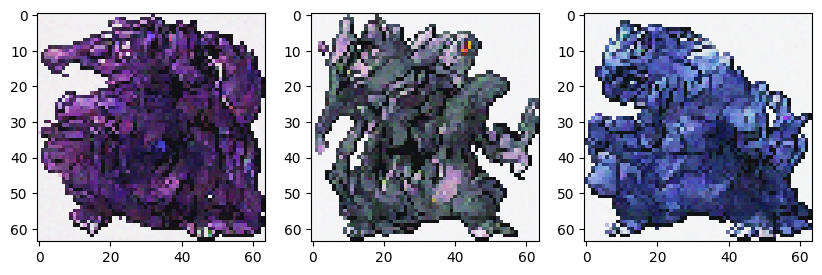

0.02331581:  61%|██████████████████████████████████████████████████████████████████▍                                          | 60999/100001 [1:29:13<56:03, 11.60it/s]

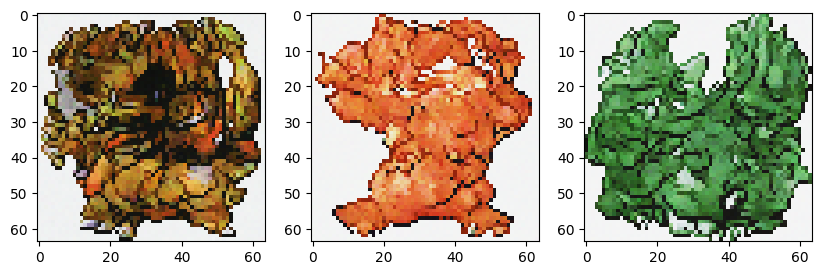

0.01343740:  62%|███████████████████████████████████████████████████████████████████▌                                         | 61999/100001 [1:30:41<54:37, 11.60it/s]

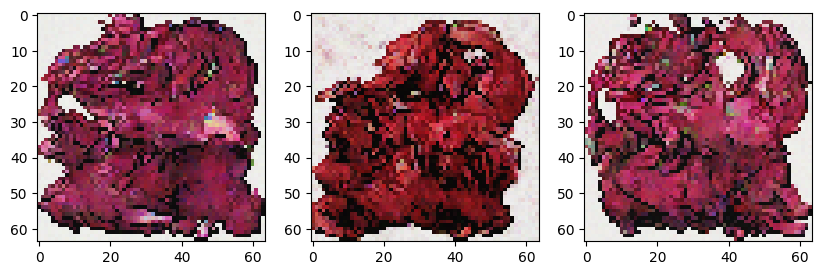

0.01666975:  63%|████████████████████████████████████████████████████████████████████▋                                        | 62999/100001 [1:32:09<53:16, 11.57it/s]

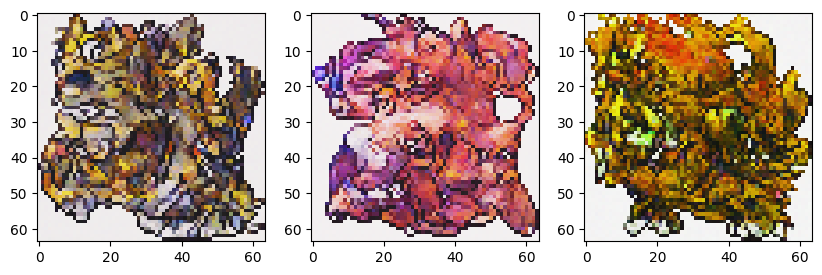

0.01722764:  64%|█████████████████████████████████████████████████████████████████████▊                                       | 63999/100001 [1:33:37<51:48, 11.58it/s]

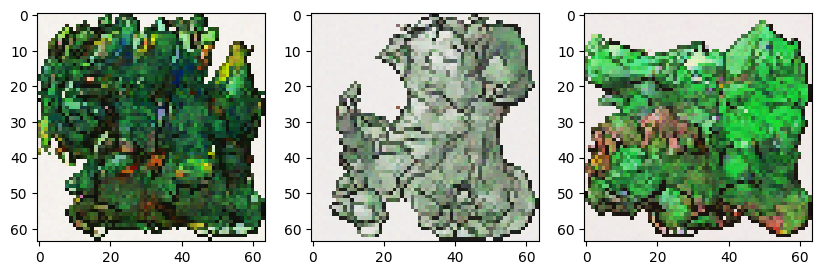

0.01440337:  65%|██████████████████████████████████████████████████████████████████████▊                                      | 64999/100001 [1:35:05<50:25, 11.57it/s]

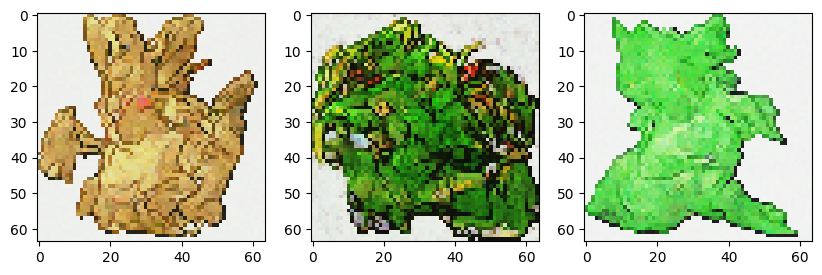

0.01325660:  66%|███████████████████████████████████████████████████████████████████████▉                                     | 65999/100001 [1:36:32<48:52, 11.59it/s]

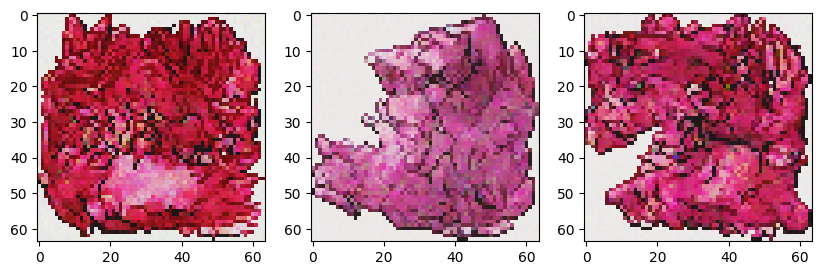

0.01395650:  67%|█████████████████████████████████████████████████████████████████████████                                    | 66999/100001 [1:38:00<47:30, 11.58it/s]

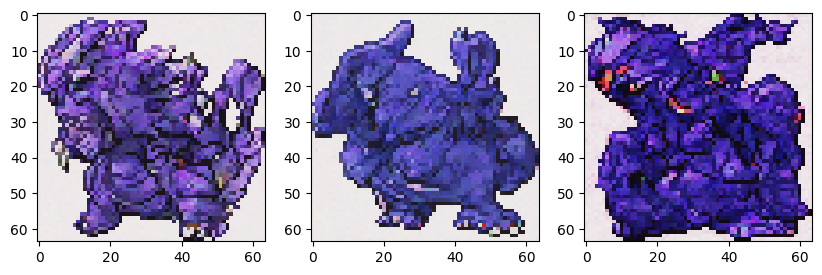

0.00768216:  68%|██████████████████████████████████████████████████████████████████████████                                   | 67999/100001 [1:39:28<46:02, 11.58it/s]

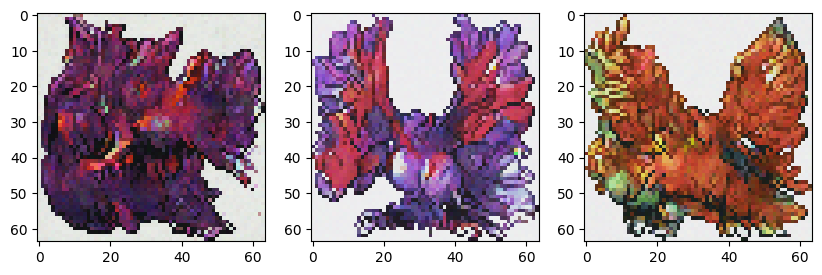

0.01830142:  69%|███████████████████████████████████████████████████████████████████████████▏                                 | 68999/100001 [1:40:56<44:36, 11.58it/s]

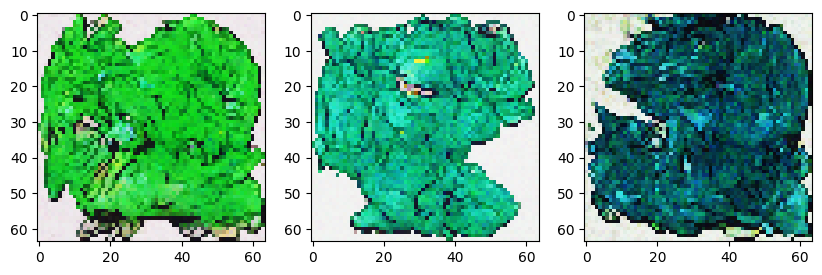

0.00953053:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 69999/100001 [1:42:23<43:11, 11.58it/s]

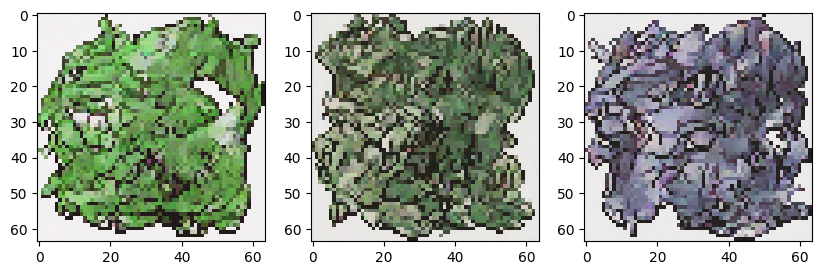

0.01683190:  71%|█████████████████████████████████████████████████████████████████████████████▍                               | 70999/100001 [1:43:51<41:41, 11.59it/s]

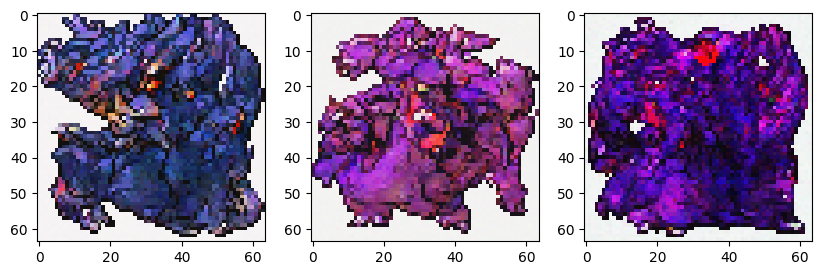

0.01566548:  72%|██████████████████████████████████████████████████████████████████████████████▍                              | 71999/100001 [1:45:19<40:13, 11.60it/s]

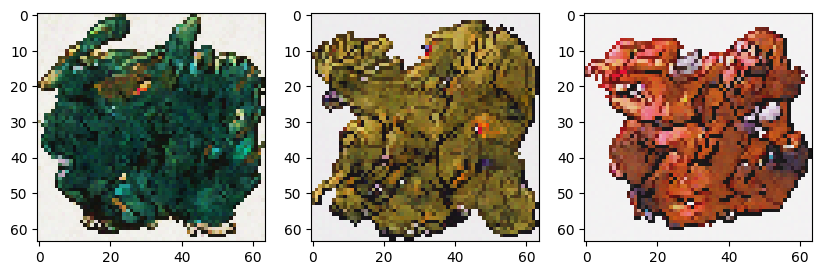

0.01021161:  73%|███████████████████████████████████████████████████████████████████████████████▌                             | 72999/100001 [1:46:46<38:46, 11.61it/s]

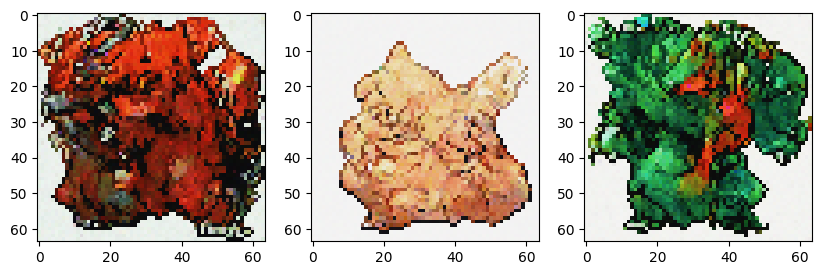

0.01431718:  74%|████████████████████████████████████████████████████████████████████████████████▋                            | 73999/100001 [1:48:14<37:22, 11.59it/s]

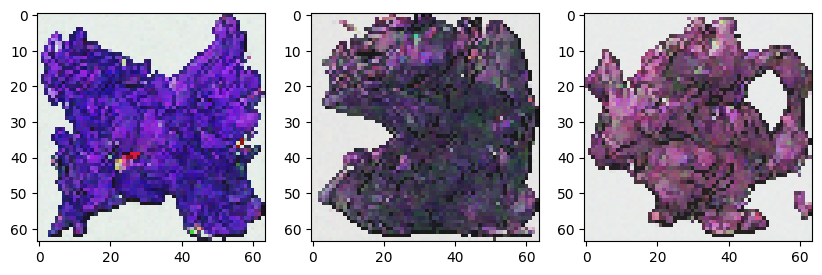

0.01402079:  75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 74999/100001 [1:49:42<35:53, 11.61it/s]

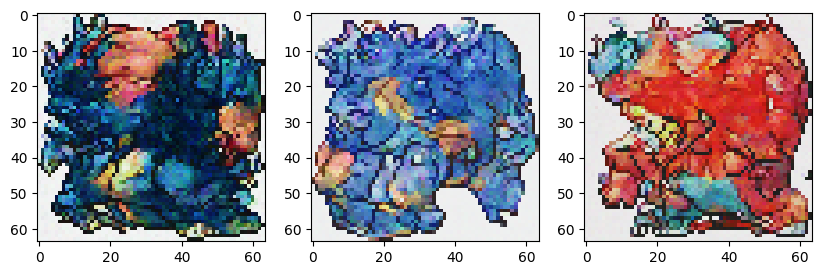

0.01206986:  76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 75999/100001 [1:51:10<34:31, 11.59it/s]

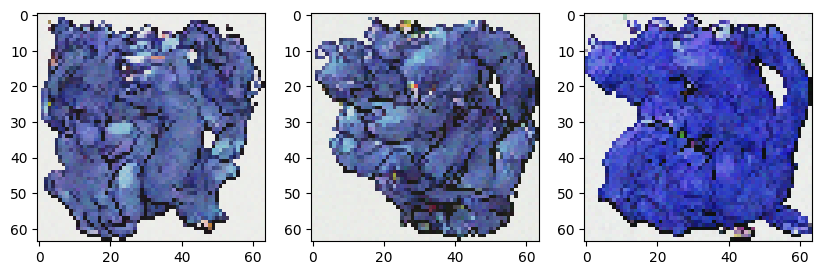

0.01551892:  77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 76999/100001 [1:52:37<33:05, 11.59it/s]

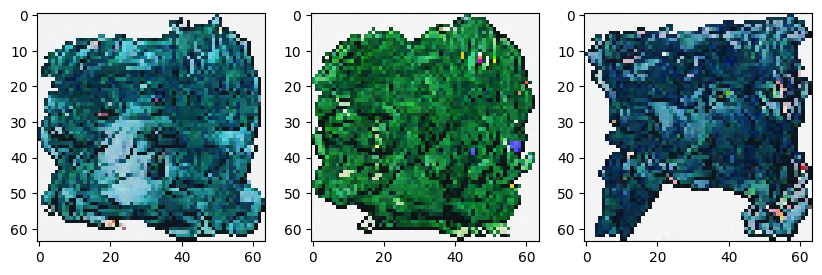

0.01673116:  78%|█████████████████████████████████████████████████████████████████████████████████████                        | 77999/100001 [1:54:05<31:37, 11.59it/s]

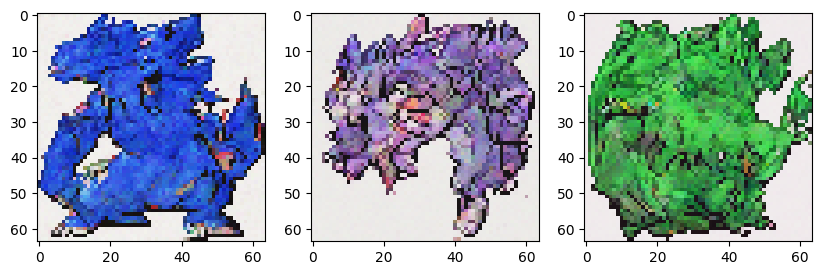

0.01693465:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 78999/100001 [1:55:33<30:15, 11.57it/s]

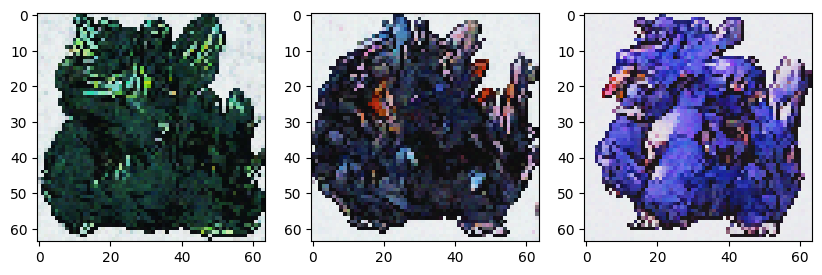

0.00866175:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 79999/100001 [1:57:01<28:47, 11.58it/s]

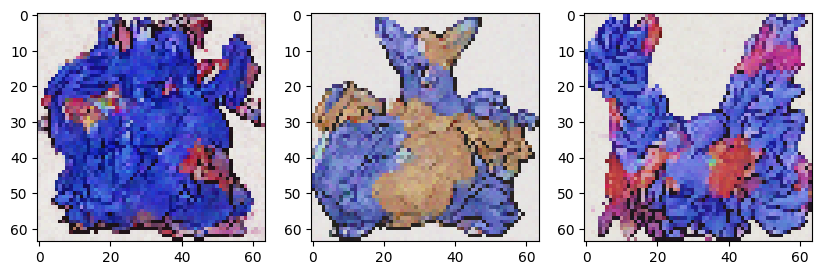

0.01557845:  81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 80999/100001 [1:58:28<27:18, 11.60it/s]

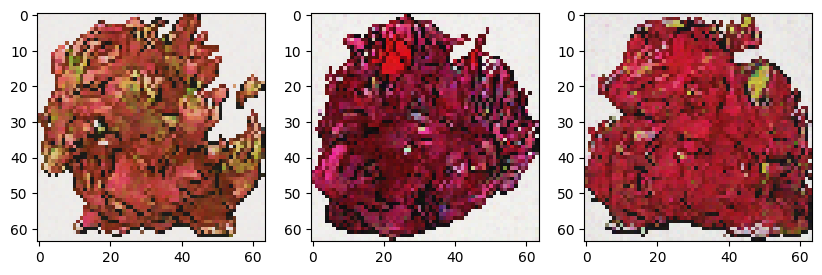

0.02385032:  82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 81999/100001 [1:59:56<25:53, 11.59it/s]

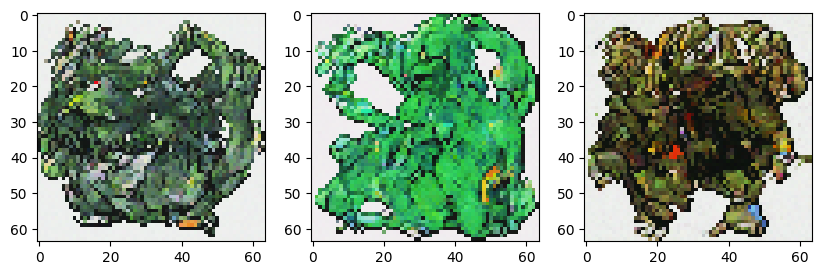

0.01089951:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 82999/100001 [2:01:24<24:28, 11.58it/s]

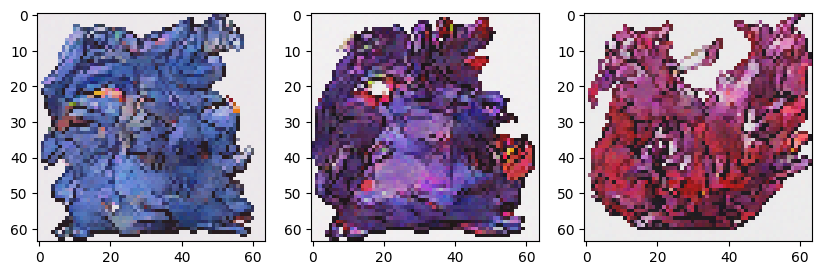

0.01897175:  84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 83999/100001 [2:02:52<23:02, 11.57it/s]

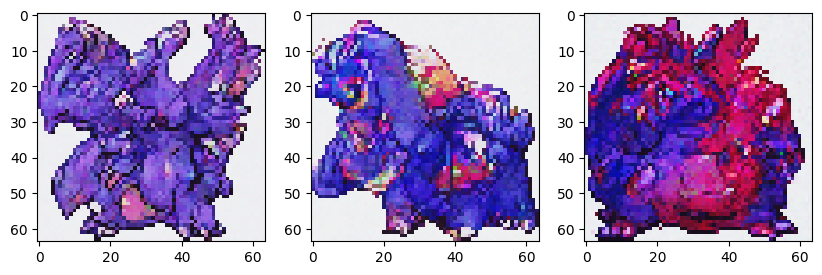

0.00852845:  85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 84999/100001 [2:04:19<21:33, 11.60it/s]

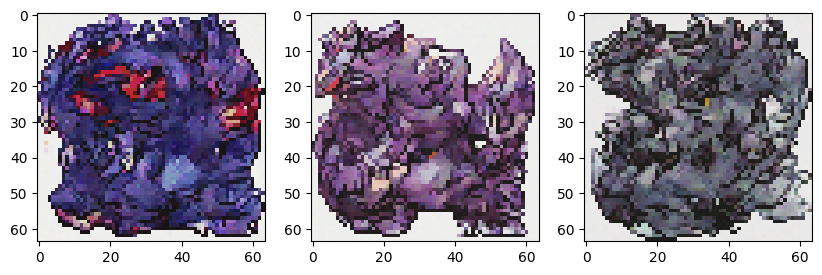

0.00632724:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 85999/100001 [2:05:47<20:08, 11.59it/s]

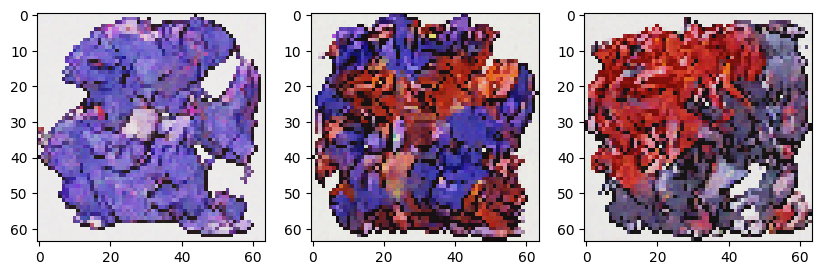

0.02579024:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 86999/100001 [2:07:15<18:41, 11.59it/s]

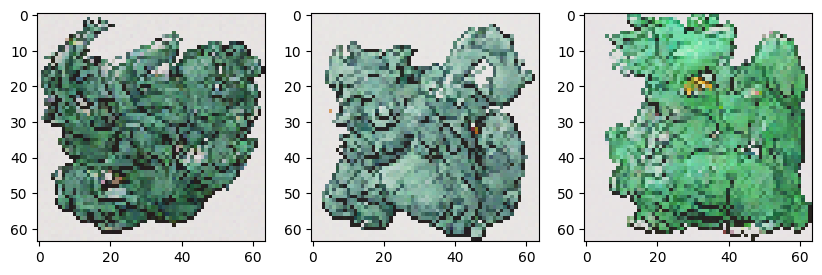

0.00855859:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 87999/100001 [2:08:43<17:15, 11.59it/s]

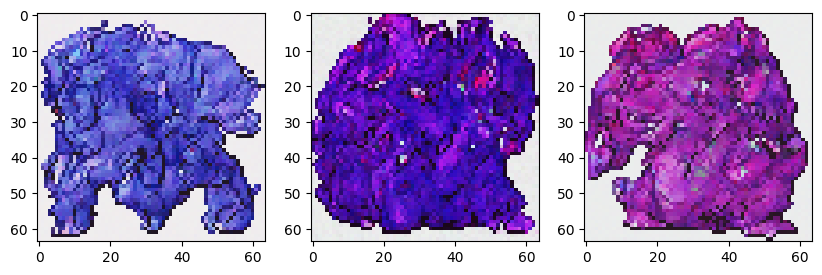

0.00999215:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 88999/100001 [2:10:10<15:50, 11.58it/s]

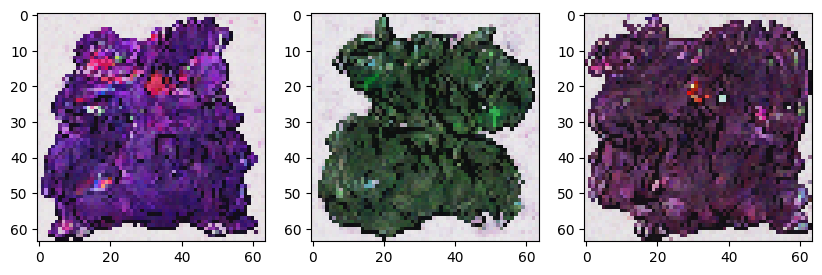

0.01142265:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 89999/100001 [2:11:38<14:21, 11.61it/s]

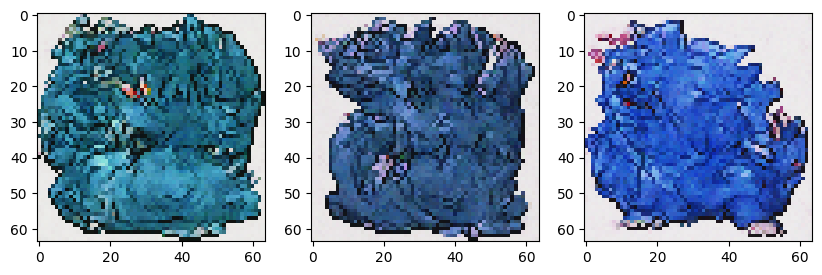

0.01277972:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 90999/100001 [2:13:06<12:56, 11.60it/s]

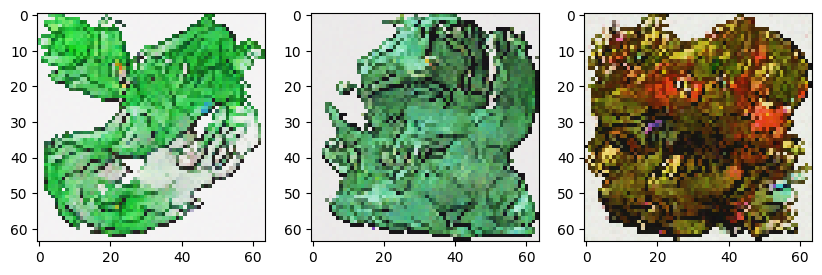

0.00792614:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 91999/100001 [2:14:33<11:30, 11.58it/s]

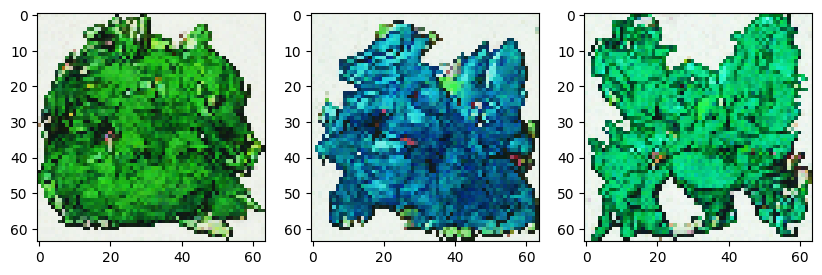

0.01168253:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 92999/100001 [2:16:01<10:04, 11.58it/s]

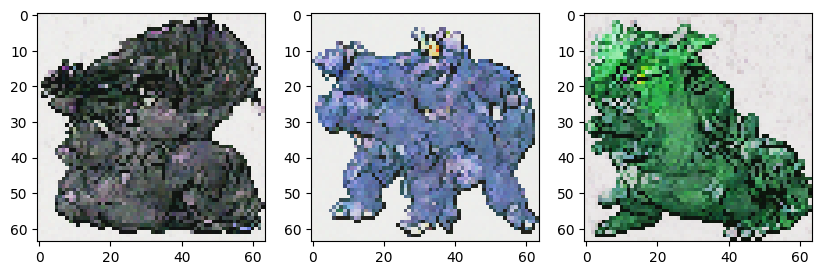

0.00864901:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 93999/100001 [2:17:29<08:38, 11.58it/s]

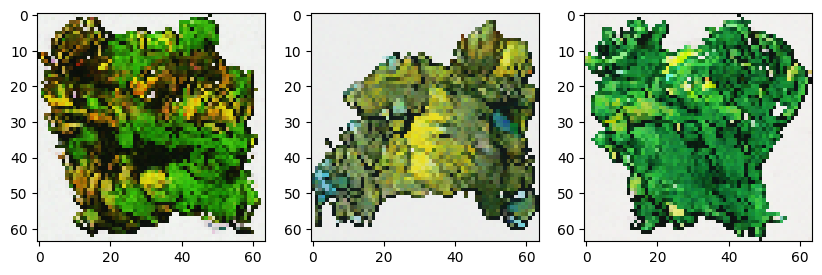

0.00796984:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 94999/100001 [2:18:57<07:10, 11.61it/s]

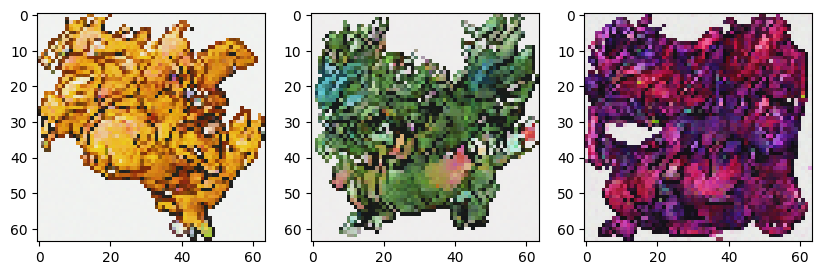

0.01185645:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 95999/100001 [2:20:24<05:45, 11.59it/s]

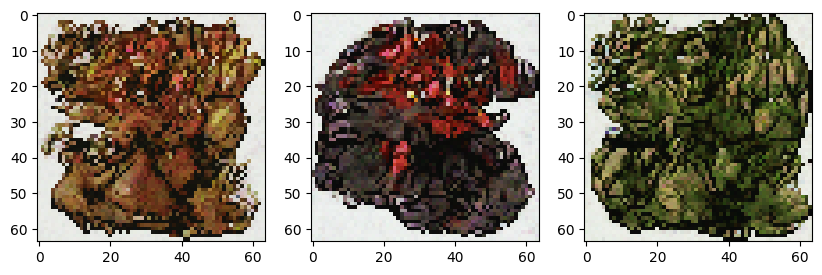

0.00901495:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 96999/100001 [2:21:52<04:19, 11.57it/s]

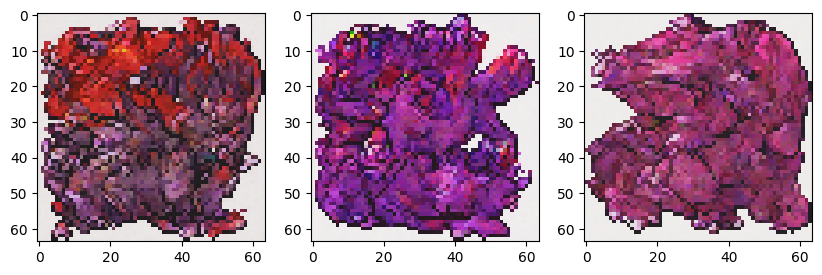

0.00916417:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 97999/100001 [2:23:20<02:52, 11.59it/s]

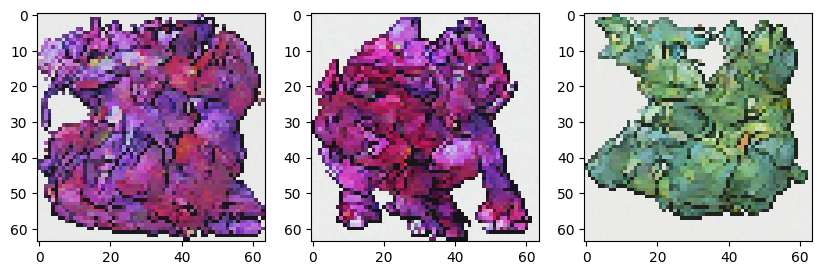

0.02485132:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 98999/100001 [2:24:48<01:26, 11.58it/s]

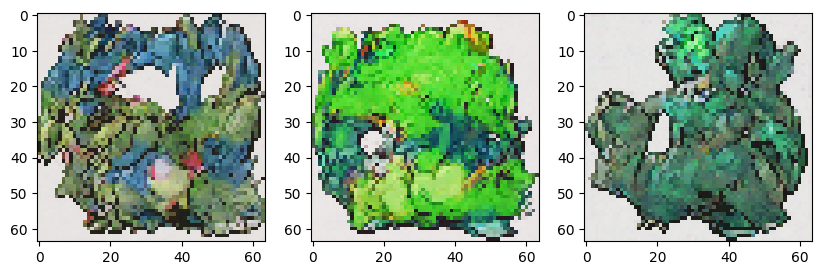

0.01119267: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 99999/100001 [2:26:15<00:00, 11.58it/s]

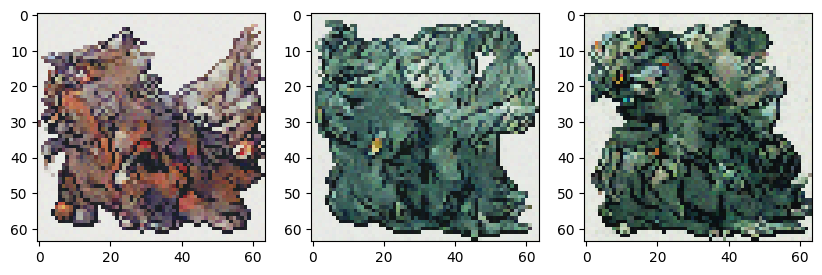

0.00600063: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [2:26:17<00:00, 11.39it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')